In [8]:
import pandas as pd

# Read the Excel file
excel_file = r'../data/weather_data.xlsx'
df = pd.read_excel(excel_file)

# Convert to CSV
csv_file = r'../data/weather_data.csv'
df.to_csv(csv_file, index=False)


In [9]:
from IPython.display import display
display(df.describe())
print('-' * 20)
display(df.head())


,Temperature,Humidity,WindSpeed
count,240.000000,240.000000,240.000000
mean,0.491528,0.478441,0.505711
std,0.284973,0.301023,0.287859
min,0.000424,0.000094,0.005566
25%,0.248846,0.203919,0.278381
50%,0.503092,0.439261,0.484471
75%,0.714775,0.740596,0.749073
max,0.997193,0.999170,0.998797


--------------------


,Temperature,Humidity,WindSpeed
0,0.671452,0.948773,0.357516
1,0.247266,0.284604,0.952821
2,0.104597,0.408139,0.618130
3,0.871093,0.320370,0.195533
4,0.073969,0.393337,0.904214


<Axes: >

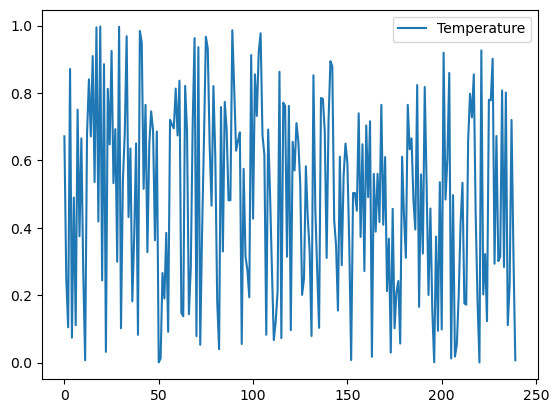

In [10]:
df_Temperature = df[['Temperature']]
df_Temperature.plot()


In [11]:
df_Temperature.iloc[0]

Temperature    0.671452
Name: 0, dtype: float64

In [12]:
import pandas as pd
###方案一：直接统计法 ：标识震荡的幅度，为1时表示单调，越小震荡越大？
def direct_statistic(df:pd.DataFrame) -> float:
    seqLength=len(df)
    S=0
    for i in range(1,seqLength):
        S +=abs(df.iloc[i,0]-df.iloc[i-1,0])
    return abs(df.iloc[seqLength-1,0]-df.iloc[0,0]) / S 
    
direct_statistic(df_Temperature)

0.008394645980570088

In [24]:
###方案二：斜率法（numpy的polyfit：用一个多项式去拟合时间序列变化，若是一次幂，取倒数的第二个系数即为斜率k，y=kx+c）
#正数：上升趋势，负数：下降趋势，0：平稳
def trendline(index: list, data: pd.DataFrame, order: int = 1) -> float:
    coeffs = np.polyfit(index, list(data), order)
    slope = coeffs[-2]
    return float(slope)

resultent = trendline(df_Temperature.index, df_Temperature['Temperature'])
print(resultent)

-0.000637222781488655


In [27]:
#方案三：Cox-Stuart趋势检验
#最后就返回p_value把，小于0.05就是显著的，可以判断上升或者下降，大于0.05就是不显著的，默认判断为无趋势
import scipy.stats as stats


def cos_staut(list_c, debug=True) -> str:
    lst = list_c.copy()
    raw_len = len(lst)
    if raw_len % 2 == 1:
        del lst[int((raw_len - 1) / 2)]
    c = int(len(lst) / 2)
    n_pos = n_neg = 0
    for i in range(c):
        diff = lst[i + c] - lst[i]
        if diff > 0:
            n_pos += 1
        elif diff < 0:
            n_neg += 1
        else:
            continue
    num = n_pos + n_neg
    k = min(n_pos, n_neg)
    p_value = 2 * stats.binom.cdf(k, num, 0.5)
    if debug:
        print("fall:%i, rise:%i, p-value:%f" % (n_neg, n_pos, p_value))
    print(n_pos)
    if n_pos > n_neg and p_value < 0.05:
        return "increasing"
    elif n_neg > n_pos and p_value < 0.05:
        return "decreasing"
    else:
        return "no trend"

cos_staut(df_Temperature['Temperature'])



fall:67, rise:53, p-value:0.235203
53


'no trend'

In [26]:
import math

from scipy.stats import mstats, norm

#MK检验：不要求数据服从正态分布，但是要求数据是独立的
#最后就返回p_value把，小于0.05就是显著的，可以判断上升或者下降，大于0.05就是不显著的，默认判断为无趋势
def mk_test(x, alpha=0.05) -> str:
    n = len(x)

    # calculate S
    s = 0
    for k in range(n - 1):
        for j in range(k + 1, n):
            s += np.sign(x[j] - x[k])

    # calculate the unique data
    unique_x, tp = np.unique(x, return_counts=True)
    g = len(unique_x)

    # calculate the var(s)
    if n == g:  # there is no tie
        var_s = (n * (n - 1) * (2 * n + 5)) / 18
    else:  # there are some ties in data
        var_s = (n * (n - 1) * (2 * n + 5) - np.sum(tp * (tp - 1) * (2 * tp + 5))) / 18

    if s > 0:
        z = (s - 1) / np.sqrt(var_s)
    elif s < 0:
        z = (s + 1) / np.sqrt(var_s)
    else:  # s == 0:
        z = 0

    # calculate the p_value
    p = 2 * (1 - norm.cdf(abs(z)))  # two tail test
    h = abs(z) > norm.ppf(1 - alpha / 2)

    if (z < 0) and h:
        trend = "decreasing"
    elif (z > 0) and h:
        trend = "increasing"
    else:
        trend = "no trend"
    print(p, h)
    return trend
mk_test(df_Temperature['Temperature'])

0.014248239151694042 True


'decreasing'

# one-hot编码示例

In [43]:
import pandas as pd

# 创建一个包含颜色和尺寸的 DataFrame
df = pd.DataFrame({
  'color': ['red', 'blue', 'green', 'red', 'blue'],
  'size': [5, 6, 7, 5, 6]
})
df['color'] = df['color'].astype(str)
# 使用 get_dummies 函数进行 One-hot 编码
df_encoded = pd.get_dummies(df, columns=['color'])
df_encoded = df_encoded.astype(int) #将原来的bool类型转换为int
df_encoded

,size,color_blue,color_green,color_red
0,5,0,0,1
1,6,1,0,0
2,7,0,1,0
3,5,0,0,1
4,6,1,0,0
